# Autocorelation: What it is, why it matters, what it tells us, and how to use it. 

### The accompanying blog post can be found here:
### NOAA dataset: 
``curl https://s3.amazonaws.com/noaa.water-database/NOAA_data.txt -o NOAA_data.txt
influx -import -path=NOAA_data.txt -precision=s -database=NOAA_water_database``


### All of my data is stored in InfluxDB. I am using the Python CL to query the data and perform autocorrelation analysis. To learn more about how to use the InfluxDB-Python CL please take a look at this post:

In [67]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from influxdb import InfluxDBClient
from pandas.plotting import autocorrelation_plot
from scipy.stats import linregress
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


<h2>1) Does our water temp data have any Autocorrelation? </h2>

<p>Connect to the client and use an influxql query to retreive and plot data.</p>

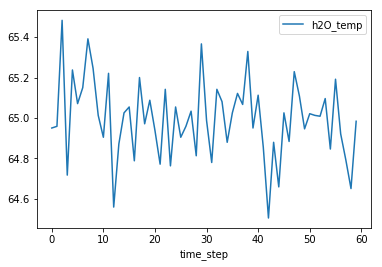

In [8]:
client = InfluxDBClient(host='localhost', port=8086)
h2O = client.query('SELECT mean("degrees") AS "h2O_temp" FROM "NOAA_water_database"."autogen"."h2o_temperature"  GROUP BY time(12h) LIMIT 60')
h2O_points = [p for p in h2O.get_points()]
h2O_df = pd.DataFrame(h2O_points)
h2O_df['time_step'] = range(0,len(h2O_df['time']))
h2O_df.plot(kind='line',x='time_step',y='h2O_temp')
plt.show()


<p>You can use .autocorr() to determine R_xx (autocorrelation) for comparisons of the data(i) with data(i-lag).</p> 

In [47]:
shift_1 = h2O_df['h2O_temp'].autocorr(lag=1)
shift_2 = h2O_df['h2O_temp'].autocorr(lag=2)
print(shift_1)
print(shift_2)

-0.07205847740103073
0.17849760131784975


<p>An autocorrelation plot is used to asses the randomness of the time series data. Random data has an R_k value close to 0 for all time lags (k) or shifts. Solid lines correspond to 95% confidence interval while dashed lines correspond to 99% confidence interval. </p>

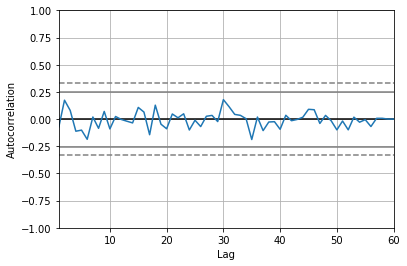

In [60]:
autocorrelation_plot(h2O_df['h2O_temp'])
plt.show()

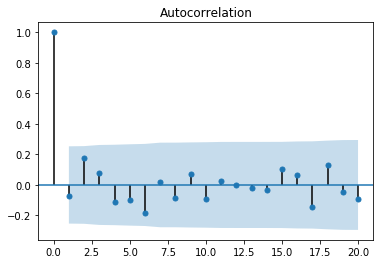

In [75]:
plot_acf(h2O_df['h2O_temp'], lags=20)
plt.show()

<p> From the graph above we can clearly see that our data displays little autocorrelation.</p>

<h2> 2) What does having little autocorrelation mean? </h2>

<p> Having no or little autocorrelation tells us our data is in fact random. Knowing this is important consideration when selecting a prediction or forecasting method. </p> 

<h2> 3) What else can autocorrelation tell us? </h2>

<h3>Let's look at the water levels. This is the same dataset that was used in this  <a href="https://www.influxdata.com/blog/how-to-use-influxdbs-holt-winters-function-for-predictions/">blog series</a> on how to use the built-in Holt-Winters Prediction algorithm. The statistical assumptions for using Holt-Winters are that the data is: a) random, b)has seasonality, and c)has trend. </h3>

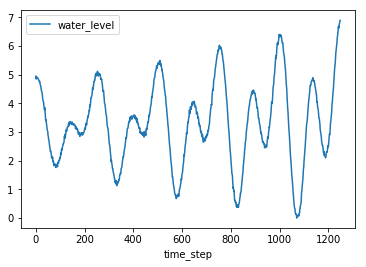

In [12]:
client = InfluxDBClient(host='localhost', port=8086)
h2O_level = client.query('SELECT "water_level" FROM "NOAA_water_database"."autogen"."h2o_feet" WHERE "location"=\'santa_monica\' AND time >= \'2015-08-22 22:12:00\' AND time <= \'2015-08-28 03:00:00\'')
h2O_level_points = [p for p in h2O_level.get_points()]
h2O_level_df = pd.DataFrame(h2O_level_points)
h2O_level_df['time_step'] = range(0,len(h2O_level_df['time']))
h2O_level_df.plot(kind='line',x='time_step',y='water_level')
plt.show()


<p> Let's verify our assumption that the data isn't random and that we can in fact use a predictor like Holt Winters </p>

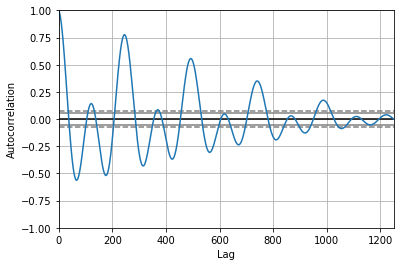

In [55]:
autocorrelation_plot(h2O_level_df['water_level'])
plt.show()

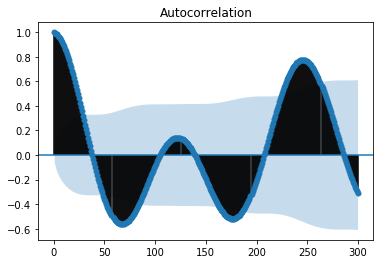

In [148]:
plot_acf(h2O_level_df['water_level'], lags=300)
plt.show()


/Users/anaisdotis-georgiou/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


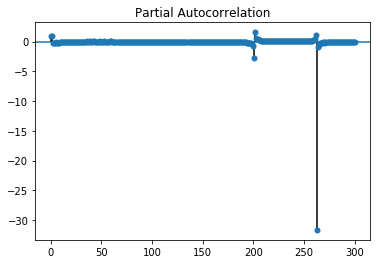

In [149]:
plot_pacf(h2O_level_df['water_level'], lags=300)
plt.show()

<p> We see that our data has significantly non-zero autocorrelation values so it is in fact random. We can also verify that our data has seasonality and trend. The autocorelation plot shows an oscillation, indicative of a seasonal series. To verify that our data has a trend, we can first remove the seasonality from our data and then take a look a the autocorrelation again.

Specifically the distance between each peak is 379m</p>

<h3> Removing seasonality: Differencing </h3>

<p> Differencing is a method of transforming a time series dataset. It can be used to remove seasonal components of the series as well as trend. In this example we'll be removing the seasonality. Taking a lag difference will allow us to do so. A lagged difference is defined by:</p>
    <p>difference(t) = observation(t) - observation(t-lag)</p>


In [260]:
from datetime import datetime 
h2O_level_df['time'].head()
h2O_level_time = [p[:-1] for p in h2O_level_df['time']]
h2O_level_time = [datetime.strptime(p,'%Y-%m-%dT%H:%M:%S') for p in h2O_level_time]


In [290]:
h2O = h2O_level_df.copy()
h2O['time'] = pd.DataFrame(h2O_level_time)
h2O.drop(columns = ['time_step'], inplace = True)
h2O.set_index('time')
h2O.head()

,time,water_level
0,2015-08-22 22:12:00,4.948
1,2015-08-22 22:18:00,4.895
2,2015-08-22 22:24:00,4.849
3,2015-08-22 22:30:00,4.918
4,2015-08-22 22:36:00,4.918


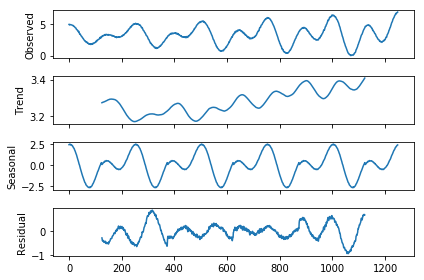

In [291]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result = seasonal_decompose(h2O['water_level'], model='additive', freq=250)
result.plot()
pyplot.show()

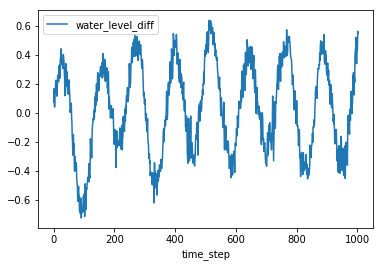

In [187]:
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff, columns = ["water_level_diff"])
h2O_level_diff = difference(h2O_level_df['water_level'], 246)
h2O_level_diff['time_step'] = range(0,len(h2O_level_diff['water_level_diff']))
h2O_level_diff.plot(kind='line',x='time_step',y='water_level_diff')
plt.show()

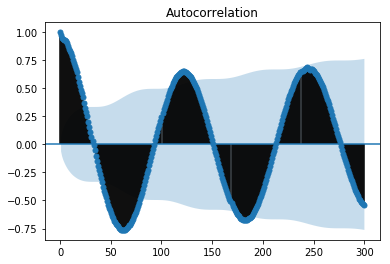

In [188]:
plot_acf(h2O_level_diff['water_level_diff'], lags=300)
plt.show()

/Users/anaisdotis-georgiou/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


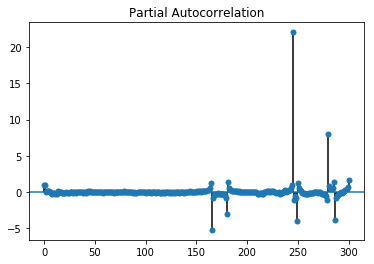

In [189]:
plot_pacf(h2O_level_diff['water_level_diff'], lags=300)
plt.show()

<h2> 4) Taking a Look at Correlation </h2>

In [43]:
h2O_level_diff_df = h2O_level_df.copy()
# h2O_level_diff_df['difference'] = [h2O_level_diff_df['water_level'][p] - h2O_level_diff_df['water_level'][p-]
h2O_level_diff_df['water_level'][0]

4.948

In [31]:
h2O_temp_array = h2O_df['h2O_temp'].values
h2O_temp_array = [float(p) for p in h2O_temp_array]
time_array = list(range(len(h2O_df['time']))) 
time_array
np.corrcoef(h2O_temp_array,time_array)[0,1]


-0.19668111286140613

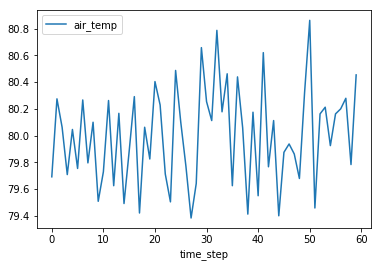

In [15]:
client = InfluxDBClient(host='localhost', port=8086)
temp = client.query('SELECT mean("degrees") as "air_temp" FROM "NOAA_water_database"."autogen"."average_temperature" Group By time(12h) limit 60')
temp_points = [p for p in temp.get_points()]
temp_df = pd.DataFrame(temp_points)
temp_df['time_step'] = range(0,len(temp_df['time']))
temp_df.plot(kind='line',x='time_step',y='air_temp')
plt.show()


### 1) Does the temperature of the water have any correlation with the temperature of the air? 

<p> Let's plot the air_temp against the h2O_temp and use visual inspection to make a hypothesis </p>

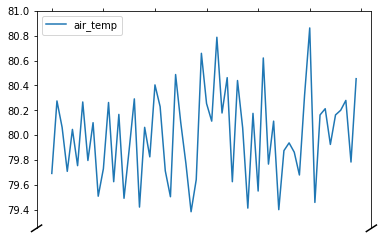

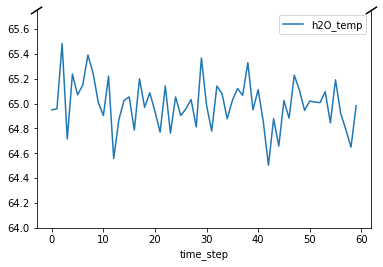

In [29]:
ax = temp_df.plot(kind='line',y='air_temp')
ax2 = h2O_df.plot(kind='line',x='time_step',y='h2O_temp')
ax.set_ylim(79.25,81)
ax2.set_ylim(64,65.75)
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=0)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
plt.show()


<p> By plotting the two together, it doesn't look like there's any sort of correlation between the two. Let's verify that assumption with a correlation plot</p>

In [28]:
h2O_air = h2O_df.copy()
h2O_air['air_temp'] = temp_df['air_temp']
h2O_air.drop(columns=['time_step'], inplace=True)
h2O_air.head()
corr = h2O_air.corr()
corr.style.background_gradient(cmap='coolwarm')


,h2O_temp,air_temp
h2O_temp,1,0.108816
air_temp,0.108816,1


<p> We see that there's a Pearson Correlation Coefficient (r) of 0.108 which indicates low correlation. This makes sense. For example, the water temperatures of a spring fed stream can stay constant the entire year. The water temperature doesn't vary with the temperature of the air. However, we expect to get a positive r value because the water temperature and air temperatures probably change in tandem. 

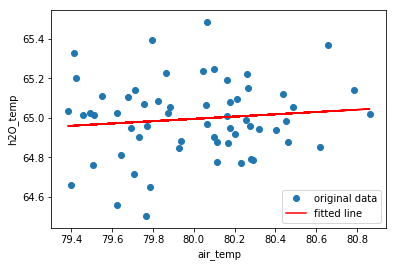

slope: 0.057999 intercept: 60.355422 r_value: 0.108816


In [41]:
h2O_air.plot(kind='scatter',x='air_temp',y='h2O_temp')
slope, intercept, r_value, p_value, std_err = linregress(h2O_air['air_temp'],h2O_air['h2O_temp'])
plt.plot(h2O_air['air_temp'], h2O_air['h2O_temp'], 'o', label='original data')
plt.plot(h2O_air['air_temp'], intercept + slope*h2O_air['air_temp'], 'r', label='fitted line')
plt.legend()
plt.show()
print("slope: %f intercept: %f r_value: %f" % (slope, intercept, r_value))